In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Balanced

In [3]:
separated_means = [[-3, 2], [-1.5, 2], [0, 2], [1.5, 2], [3, 2], [-3, 0], [-1.5, 0], [0, 0], [1.5, 0], [3, 0]]
overlapped_means = [[-2, 1], [-1.5, 1], [0, 1], [1.5, 1], [2, 1], [-2, 0], [-1.5, 0], [0, 0], [1.5, 0], [2, 0]]
highly_overlapped_means = [[-2, 1], [-1.5, 1], [-1, 1], [-0.5, 1], [0, 1], [-2, 0], [-1.5, 0], [-1, 0], [-0.5, 0], [0, 0]]

In [4]:
size_per_category = 1000

In [5]:
palette = ['red', 'green', 'blue', 'cyan', 'magenta', 'orange', 'yellow', 'lightgreen', 'skyblue', 'orchid']

In [6]:
def generate_distribution(mean_array, size_per_category):
    points = pd.DataFrame()
    x = []
    y = []
    category = []
    index = 0
    for mean in mean_array:
        gaussian_normal_points = np.random.normal(loc=mean, scale=[0.3,0.3], size=[size_per_category, 2])
        x += list(gaussian_normal_points[:, 0])
        y += list(gaussian_normal_points[:, 1])
        category += [index] * size_per_category
        index += 1
    points['x'] = x
    points['y'] = y
    points['category'] = category
    return points

In [7]:
def plot_distribution(distribution):
    legend = [('Category '+ str(index+1)) for index in range(10)]
    plt.figure(figsize=(15,8))
    for index in range(10):
        data = distribution[distribution['category'] == index]
        plt.scatter(data['x'], data['y'], c=palette[index], s=5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend((legend), loc=1)

In [8]:
separated = generate_distribution(separated_means, size_per_category)
#plot_distribution(separated)

In [9]:
overlapped = generate_distribution(overlapped_means, size_per_category)
#plot_distribution(overlapped)

In [10]:
highly_overlapped = generate_distribution(highly_overlapped_means, size_per_category)
#plot_distribution(highly_overlapped)

# Imbalanced

Run for r in [0.01, 0.05, 0.1, 0.5, 0.9] and m in [1,9]

Simulating for one test case:

In [11]:
m = 2
r = 0.01
k = 10
imbalanced_size = 2000

In [12]:
def sample_imbalanced_data(data, imbalanced_size, m, r, k):
    p_min = r/10 #for m classes
    p_max = (1 - (p_min * m))/(k - m) #for k-m classes
    minority_positions = ([p_min] * m + [p_max] * (k - m))
    np.random.shuffle(minority_positions)
    class_probabilities = [(proba/size_per_category) for proba in minority_positions]
    p = [class_probabilities[category] for category in data['category']]
    indices = np.arange(len(data))
    selected_indices = np.random.choice(indices, imbalanced_size, p=p)
    imbalanced_samples = data.iloc[selected_indices, :]
    imbalanced_samples.reset_index(inplace=True, drop=True)
    return imbalanced_samples

In [13]:
separated_imbalanced = sample_imbalanced_data(separated, imbalanced_size, m, r, k)
#plot_distribution(separated_imbalanced)

In [14]:
overlapped_imbalanced = sample_imbalanced_data(overlapped, imbalanced_size, m, r, k)
#plot_distribution(overlapped_imbalanced)

In [15]:
highly_overlapped_imbalanced = sample_imbalanced_data(highly_overlapped, imbalanced_size, m, r, k)
#plot_distribution(highly_overlapped_imbalanced)

In [16]:
def imbalance_ratio(data):
    value_counts = data['category'].value_counts()
    counts = [count for category, count in value_counts.iteritems()]
    count_max = max(counts)
    count_min = min(counts)
    IR = count_max / count_min
    return IR

In [17]:
def hellinger_distance(vec1, vec2):
    return np.sqrt(np.sum((np.sqrt(vec1) - np.sqrt(vec2)) ** 2)) / np.sqrt(2)

In [18]:
def imbalance_degree(data, c):
    value_counts = data['category'].value_counts()
    counts = [count for category, count in value_counts.iteritems()]
    size = len(data)
    p = np.array(counts) / size
    if (len(p) < c):
        p = np.concatenate((p, [0] * (c-len(p))))
    b = [1/c] * c
    m = 0
    for prob in (p-b):
        if prob < 0:
            m +=1
    p_m = [0] * m + [1/c] * (c-m-1) + [1-(c-m-1)/c]
    ID = (hellinger_distance(p,b) / hellinger_distance(p_m,b)) + (m-1)
    return ID

In [19]:
def log_likelihood_index(data):
    c = len(np.unique(data['category']))
    b = np.array([1/c] * c)
    value_counts = data['category'].value_counts()
    size = len(data)
    proba = [(count/size) for category, count in value_counts.iteritems()]
    n = [count for _, count in value_counts.iteritems()]
    summation = np.sum([(p*np.log(p*c)) for p in proba])
    LLI = 2 * summation
    return LLI

In [53]:
def tangential_imbalance_degree(data):
    targets = data['category']
    unique, n = np.unique(targets, return_counts=True)
    c = len(unique)
    N = len(targets)
    b = [1/c] * c
    p = n / N
    unique = unique
    counts = n
    ic = -2 * p*np.tan(b-p)
    signs = np.array([-1 if x < 0 else 1 for x in ic])
    #ic = np.sqrt(np.absolute(ic)) * signs
    tid = np.absolute(np.sum(ic))
    return tid

# Simulating for all values

In [54]:
def compute_graphs(distribution, imbalanced_size, k):
    results = []
    for m in range(1,k):
        IR = []
        ID = []
        LLI = []
        TID = []
        for r in [0.01, 0.05, 0.1, 0.5, 0.9]:
            imbalanced_data = sample_imbalanced_data(distribution, imbalanced_size, m, r, k)
            IR.append(imbalance_ratio(imbalanced_data))
            ID.append(imbalance_degree(imbalanced_data, k))
            LLI.append(log_likelihood_index(imbalanced_data))
            TID.append(tangential_imbalance_degree(imbalanced_data))
        result = {}
        result['ir'] = IR
        result['id'] = ID
        result['lli'] = LLI
        result['tid'] = TID
        results.append(result)
    return results

In [55]:
def plot_graph(distribution, metric, legend, k=10, imbalanced_size=5000):
    data_points = compute_graphs(distribution, imbalanced_size, k)
    #plt.figure(figsize=(10,6))
    index = 0
    r_values = [0.01, 0.05, 0.1, 0.5, 0.9999]
    legend = [('m = ' + str(i)) for i in range(1,10)]
    for category in data_points:
        scores = category[metric]
        plt.plot(r_values, scores)
        plt.xlabel('r')
        plt.ylabel(metric.upper())
        #print(scores)
    plt.legend((legend), loc=1, fontsize='medium', framealpha=0.2)

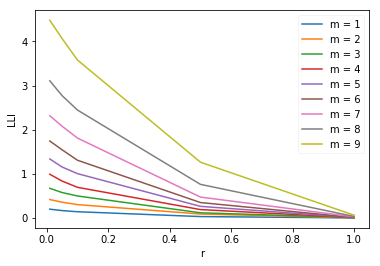

In [56]:
plot_graph(highly_overlapped, 'lli', legend=True)

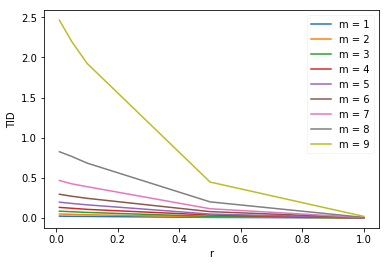

In [57]:
plot_graph(highly_overlapped, 'tid', legend=True)